In [ ]:
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import OpenSSL.SSL
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (10, 5)

# This import is needed to suppress warnings, not sure why thera are warnings.
import warnings
warnings.simplefilter('error')

# Set the context: Run computation on cpus
data_ctx = mx.cpu()
model_ctx = mx.cpu()

C:\Users\gilbe\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Deep Learning Demo

### Neural Networks

### Recurrent Neural Networks

### Optimization with Gradient Descent



### Deep Learning Framworks
* tensorflow
* Keras
* pytorch
* CNTK
* MXNet
* etc

### Linear Regression with MXNet
Estimate the parameters $\mathbf{w}$ and $b$ with a linear model of the form:
\begin{equation}
\hat{y} = \mathbf{w} \cdot \mathbf{X}^T + b
\end{equation}

To assess how well our predictions are with respect to the true targets we use the square loss:
\begin{equation}
L(y, \hat{y}) = \sum_{i=1}^n (\hat{y}_i - y_i)^2 
\end{equation}





## Example from finance: Prediction of prices for next day
Data is loaded from tiingo, a platform for free and licensed financial data
Other vendors include QUANDL, QUANTOPIA ETC.

### Load and preprocess data

In [ ]:
data = pd.read_csv('closing_prices_tiingo.csv', parse_dates=True, infer_datetime_format=True)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head()

,AAPL,ABBV,ABT,AMGN,AMZN,AVGO,BA,BAC,BMY,C,...,PFE,PG,PM,T,UNH,V,VZ,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,27.294495,NaN,21.129273,49.792737,133.90,16.673423,45.640616,14.639460,19.648366,32.843185,...,13.934719,47.114847,34.709530,18.323770,27.878733,20.694802,20.828887,22.385830,43.935552,53.998112
2010-01-05,27.341684,NaN,20.958563,49.365427,134.69,16.797192,47.135432,15.115313,19.341720,34.098954,...,13.735967,47.130264,34.407096,18.234010,27.834524,20.457660,20.566022,23.000375,43.498060,54.208950
2010-01-06,26.906778,NaN,21.074956,48.994453,132.25,16.929801,48.565255,15.292591,19.334054,35.161528,...,13.691800,46.906716,34.407096,17.971143,28.108625,20.182950,20.274994,23.033151,43.400840,54.677481
2010-01-07,26.857038,NaN,21.249546,48.545833,130.00,16.823714,50.531263,15.796435,19.349386,35.258126,...,13.640272,46.652332,34.836130,17.769366,29.187345,20.370786,20.154309,23.868932,43.425145,54.505686
2010-01-08,27.035592,NaN,21.358180,48.977198,133.52,16.947483,50.043823,15.656478,19.027407,34.678540,...,13.750689,46.590664,34.646230,17.639188,28.913244,20.427137,20.167013,23.647696,43.206399,54.287039


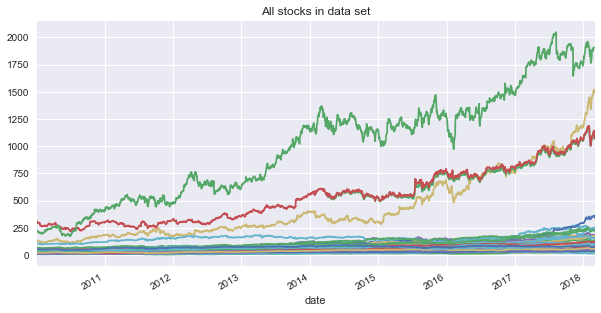

In [ ]:
data.plot(legend=False, title='All stocks in data set')
plt.show()

In [ ]:
aapl = data['AAPL']
aapl.head()

date
2010-01-04    27.294495
2010-01-05    27.341684
2010-01-06    26.906778
2010-01-07    26.857038
2010-01-08    27.035592
Name: AAPL, dtype: float64

## Plot the price data

In [ ]:
def to_return(x, period=1):
    """ This function supposes that the input is a
    dataframe or series"""
    return (x - x.shift(periods=period, axis='index'))/x.shift(periods=period)

We are using the pandas API to plot(), pandas knows we are plotting a time series and sets the time axis automatically.


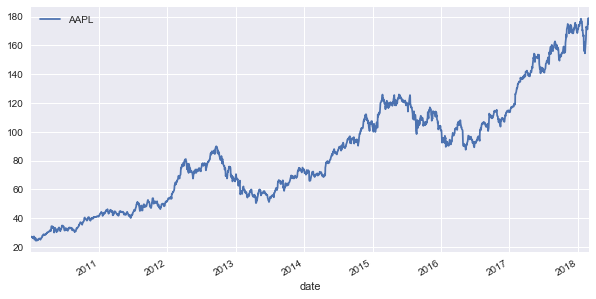

In [ ]:
aapl.plot(legend=True)
plt.show()

In [ ]:
Returns are computed as
\[R_{t+1} = \frac{P_{t+1}}{}
    
    \]

date
2010-01-04         NaN
2010-01-05    0.001729
2010-01-06   -0.015906
2010-01-07   -0.001849
2010-01-08    0.006648
Name: AAPL, dtype: float64
Shape of data: (2055,)


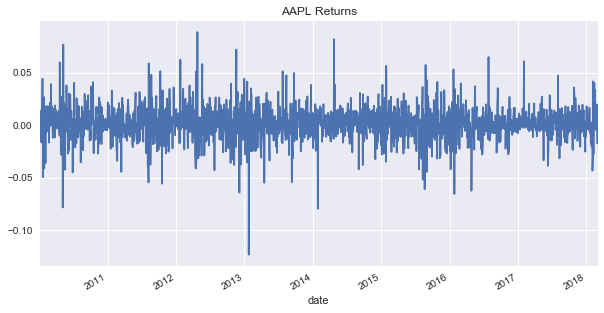

In [ ]:
ret = to_return(aapl)
print(ret.head())
print('Shape of data: {}'.format(ret.shape))
ret.plot(title='AAPL Returns')
plt.show()

## Divide in training and test sets
* Because we are working with time series where order matters we will not randomize the data sets. 
* Randomization is otherwise done in data sets where the assumption of independent and identically distributed (i.i.d.) applies. 

Start by transforming data to a rolling window of x daily returns/prices, depending on the data to predict on. For example for a window of 30 days:
\begin{equation}
\{S_{t-29}, S_{t-28}, \dots, S_{t}\}
\end{equation}
where $t\geq 30$

In [ ]:
def to_tensor(data, timesteps=30):
    x = np.array([data[i:i + timesteps]
                  for i in range(len(data) - timesteps)], dtype=float)
    return x

In [ ]:
input_tensor = to_tensor(aapl, timesteps=31)

input_tensor.shape

(2024, 31)